In [1]:
#!conda install -c conda-forge -c anaconda -y pygraphviz networkx
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


# Class generate jobs

In [2]:
from src.ProfileGenerator import ProfileGenerator
from src.JobGenerator import JobGenerator

In [16]:
#Generate file

LOAD_FROM_FILE = False
MAX_RESOURCES = 4

prof_gen = ProfileGenerator(max_resources=MAX_RESOURCES)

if(LOAD_FROM_FILE):
    with open('profiles.json', 'r') as f:
        json_str = f.read()
        profiles = prof_gen.load_from_json(json_str)
else:
    profiles = prof_gen.generate(number_of_profiles=100, low_percent=0.6, med_percent=0.4, high_percent=0)

# Generate Jobs

In [22]:
import networkx as nx
import numpy as np

def linearly_increasing_probability(t):
    return t / 3600  # Aumenta linealmente hasta 1 en una

def cyclic_poisson_probability(t, base_lambda=0.05, amplitude=0.04, period=3600):
    # Variar lambda con una función sinusoidal
    lambda_t = base_lambda + amplitude * np.sin(2 * np.pi * t / period)
    
    # Probabilidad de 0 eventos en el intervalo de tiempo t usando el lambda variante
    prob_0 = np.exp(-lambda_t)
    
    # Probabilidad de al menos 1 evento en el intervalo de tiempo t
    return 1 - prob_0

base_graph = nx.DiGraph()
# Añadir nodos y aristas principales
base_graph.add_edge(0, 1)
base_graph.add_edge(1, 2)
base_graph.add_edge(2, 3)
base_graph.add_edge(3, 4)

# Añadir dependencias cruzadas
base_graph.add_edge(0, 2)  # Nodo 0 también influye en el nodo 2
base_graph.add_edge(1, 3)  # Nodo 1 también influye en el nodo 3
base_graph.add_edge(2, 4)  # Nodo 2 también influye en el nodo 4

# Añadir nodos y aristas adicionales para mayor complejidad
base_graph.add_edge(0, 5)
base_graph.add_edge(5, 6)
base_graph.add_edge(6, 4)  # Nodo 6 influye en el nodo 4
base_graph.add_edge(3, 6)  # Nodo 3 también influye en el nodo 6

job_gen = JobGenerator(profiles)
# revisa el batch cada 1 hora, por 3 días
job_gen.generate_variable_dag(cyclic_poisson_probability, base_graph, check_interval=60, duration=259200)

In [23]:
job_gen.generate_jobs_dataframe()

,id,profile,res,subtime,walltime,dependencies
0,0,low_16,1,60,9.099608,None
1,1,low_37,1,60,3.010195,0
2,2,low_16,1,60,9.099608,"0, 1"
3,3,low_7,1,60,6.471191,"1, 2"
4,4,low_59,1,60,3.035017,"2, 3, 6"
...,...,...,...,...,...,...
1444,1444,med_89,1,257880,1031.434415,"1442, 1443"
1445,1445,low_25,1,257880,16.601977,"1443, 1444"
1446,1446,med_82,2,257880,1194.789938,"1444, 1445, 1448"
1447,1447,low_40,1,257880,1.679137,1442


In [24]:
job_gen.generate_jobs_json('workload')

/home/jovyan/.local/lib/python3.8/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: neato: graph is too large for cairo-renderer bitmaps. Scaling by 0.196755 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


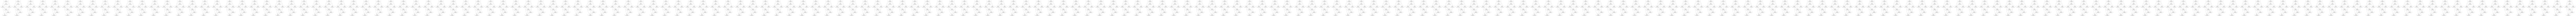

In [25]:
job_gen.visualize_with_subtime_annotations_dot()

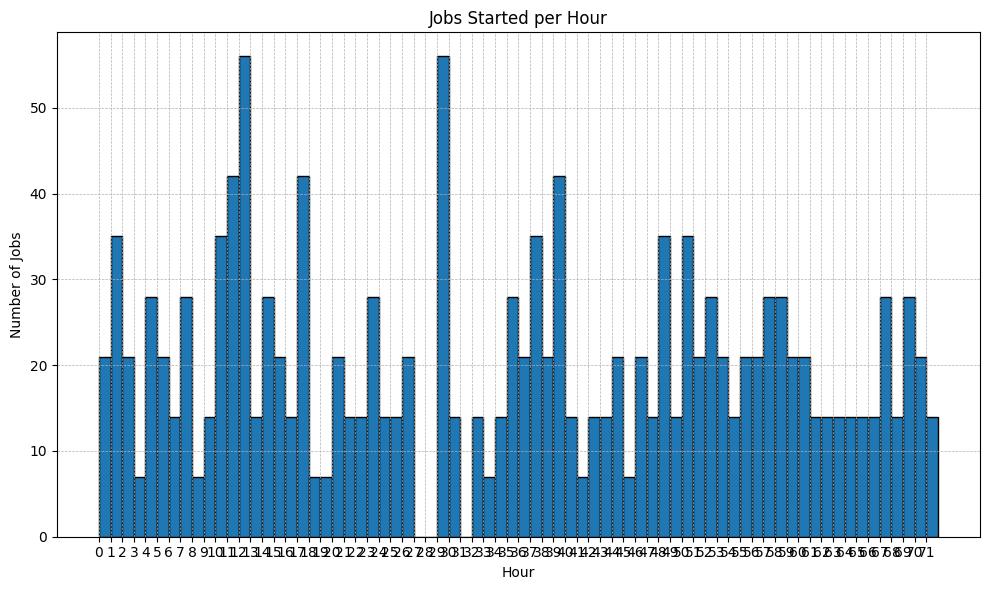

In [27]:
import matplotlib.pyplot as plt
import json
import numpy as np

def plot_jobs_per_hour(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        
    # Extrayendo información de los trabajos
    jobs = data['jobs']
    start_times = [job['subtime'] for job in jobs]
    
    # Convertir segundos a horas
    start_times_in_hours = [time / 3600 for time in start_times]
    
    # Determinar el rango de horas
    min_hour = int(min(start_times_in_hours))
    max_hour = int(max(start_times_in_hours)) + 1  # +1 para incluir la última hora
    
    # Creando histograma
    bins = np.arange(min_hour, max_hour + 1)  # +1 para el límite final
    hist, bin_edges = np.histogram(start_times_in_hours, bins=bins)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(bin_edges[:-1], hist, width=1, align='edge', edgecolor='black')
    ax.set_xticks(bin_edges[:-1])
    ax.set_xticklabels([f"{int(i)}" for i in bin_edges[:-1]])
    ax.set_xlabel('Hour')
    ax.set_ylabel('Number of Jobs')
    ax.set_title('Jobs Started per Hour')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

# Usar la función para mostrar el gráfico por hora
plot_jobs_per_hour('workload.json')

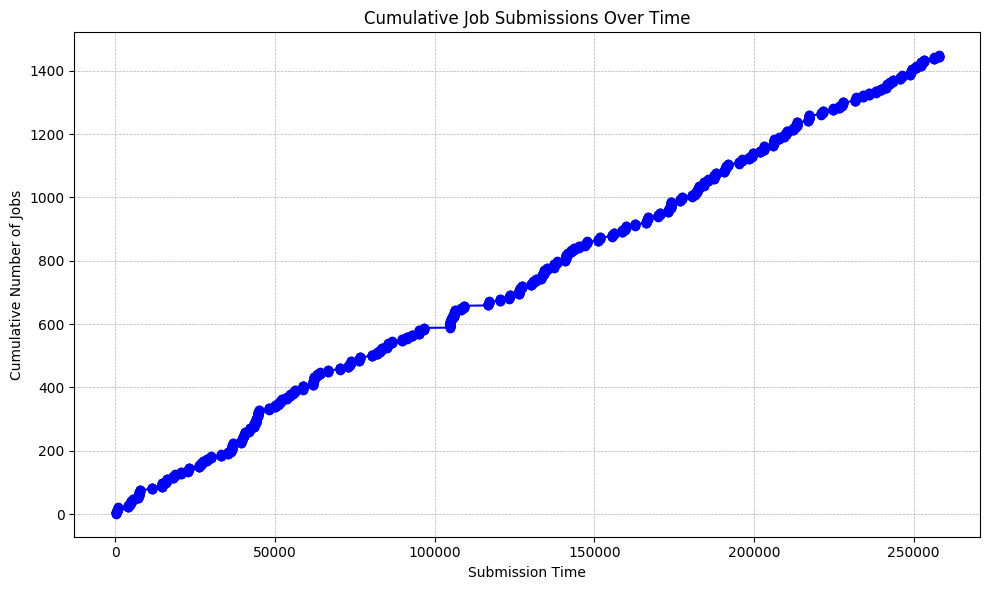

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Load the generated jobs from the JSON
with open("workload.json", "r") as file:
    workload_data = json.load(file)

# Extract subtimes
subtimes = [job["subtime"] for job in workload_data["jobs"]]

# Sorting subtimes
sorted_subtimes = np.sort(subtimes)

# Create a cumulative count of jobs for each unique subtime
cumulative_counts = np.arange(1, len(sorted_subtimes) + 1)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_subtimes, cumulative_counts, marker='o', linestyle='-', color='b')
plt.title("Cumulative Job Submissions Over Time")
plt.xlabel("Submission Time")
plt.ylabel("Cumulative Number of Jobs")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [29]:
!cp workload.json ../../workloads/
!cp workload_dependencies.json ../../workloads/